In [55]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model

import numpy as np


base_model = ResNet50(weights='imagenet')
input_img = base_model.input

base_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2D (None, 230, 230, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256                                          
___________________________________________________________________________________________

In [56]:
layer = base_model.get_layer('conv1')

In [57]:
from keras import backend as K

filter_index = 61
layer_output = layer.output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [58]:
img_width = 224
img_height = 224


input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

In [59]:
for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * 1


In [60]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = deprocess_image(input_img_data[0])

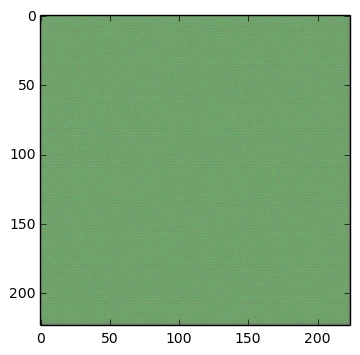

In [61]:
%matplotlib inline
from matplotlib.pyplot import imshow 
imshow(img)